In [1]:
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import LeaveOneOut
import os

from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score
from sklearn.preprocessing import label_binarize

output_fold = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/results/ML_results'
if not os.path.exists(output_fold):
    os.makedirs(output_fold)


def get_metrics(y_true, y_pred):
    # tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # 明确指定labels参数
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    # 现在cm是一个2x2矩阵，即使数据只包含一个类别
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1 = f1_score(y_true, y_pred)

    return accuracy, sensitivity, specificity, f1


res = {}

# 初始化模型，同时设置随机种子
models = {
    # "Logistic Regression": LogisticRegression(max_iter=150),
    "Decision Tree": DecisionTreeClassifier()
}
for name, model in models.items():
    # run multiple time, using different time stamp as random seed
    for num_time in range(1):
        print(f'current training {name}, num_time: {num_time}')

        # 使用当前时间戳作为随机种子
        current_time_seed = 1706166341

        # build model
        model.random_state = current_time_seed

        hb_result = {}
        HB_TYPE_accuraies = {}
        HB_TYPE_y_pred_and_y_test = {}
        for HB_TYPE in ['HbO', 'HbR', 'HbO+HbR']:
            HB_TYPE_accuraies[HB_TYPE] = []
            HB_TYPE_y_pred_and_y_test[HB_TYPE] = []

            # read data
            fold = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/prognosis/pre_treatment_hamd_reduction_50'

            hb = np.load(fold + '/data.npy')
            label = np.load(fold + '/label.npy')

            if HB_TYPE == 'HbO':
                hb = hb[..., :hb.shape[-1]//2]
            elif HB_TYPE == 'HbR':
                hb = hb[..., hb.shape[-1]//2:]
            hb_2d = np.reshape(hb, (hb.shape[0], -1))

            # Apply LOOCV to train the model
            # Initialize LeaveOneOut
            loo = LeaveOneOut()

            # 存储每个模型的准确率
            accuracies = {}

            # Loop over each train/test split
            for train_index, test_index in loo.split(hb_2d):
                # Split the data into training and testing sets
                X_train, X_test = hb_2d[train_index], hb_2d[test_index]
                y_train, y_test = label[train_index], label[test_index]

                # Train the classifier
                model.fit(X_train, y_train)

                # Predict the label for the test set
                y_pred = model.predict(X_test)

                # Calculate the accuracy for the current fold
                accuracy = accuracy_score(y_test, y_pred)

                # Append the accuracy to the list
                HB_TYPE_accuraies[HB_TYPE].append(accuracy)

                HB_TYPE_y_pred_and_y_test[HB_TYPE].append([y_pred, y_test])
            accuracies[HB_TYPE] = 1
            accuracies[HB_TYPE] = np.mean(HB_TYPE_accuraies[HB_TYPE])

        save_result = {}
        save_result['accuracies'] = accuracies
        save_result['model_accuraies'] = HB_TYPE_accuraies
        save_result['current_time_seed'] = current_time_seed
        save_result['num_time'] = num_time
        save_result['HB_TYPE_y_pred_and_y_test'] = HB_TYPE_y_pred_and_y_test

        res[f'{num_time}'] = save_result
    # np.save(output_fold + f'/{name}_result_validate.npy', res)

current training Decision Tree, num_time: 0


In [12]:
save_result['accuracies']

{'HbO+HbR': 0.8769230769230769}

In [2]:
feature_importances = model.feature_importances_
print("特征重要性：", feature_importances)


特征重要性： [0. 0. 0. ... 0. 0. 0.]


(52, 2502)
(2502,)


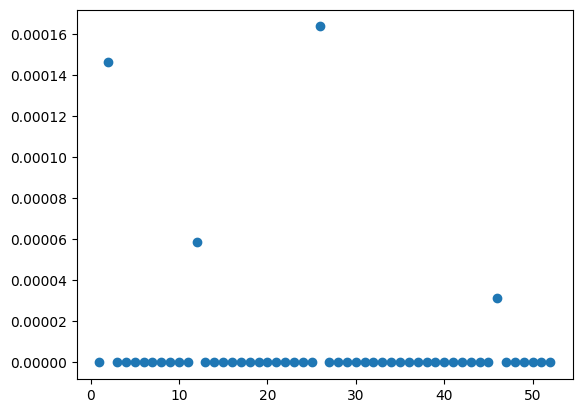

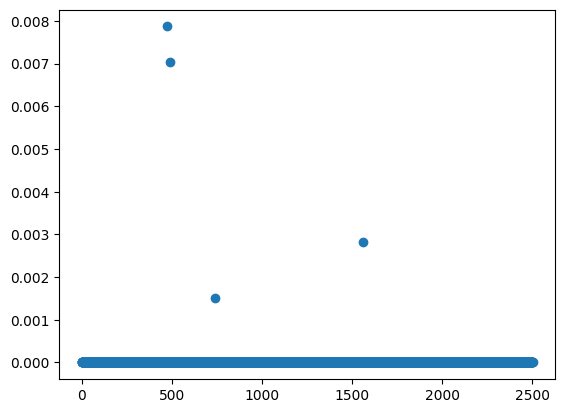

In [24]:
import matplotlib.pyplot as plt
feature_importances = np.reshape(feature_importances, (hb.shape[1], -1))
print(feature_importances.shape)
channel_importance = np.mean(feature_importances, axis=1)
plt.scatter(range(1,53),channel_importance)


plt.figure()
time_importance = np.mean(feature_importances, axis=0)
print(time_importance.shape)
plt.scatter(range(1,time_importance.shape[0]+1),time_importance)